In [2]:
%reload_ext autoreload
%autoreload 2 
import numpy as np
import matplotlib.pyplot as plt  

from env import SingleStateSpace 
from env import DoubleStateSpace
from RewardFunctions import SingleStateReward
from RewardFunctions import DoubleStateReward

from policy_walk import PolicyWalk 
from priors import UniformPrior 
from priors import TimeDependentPrior

from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import policy_iteration

In [9]:
#Set up the environment
#Number of traejectories doesn't have as significant as effect as trajectory_length because this actually affects the size of the reward tensors 
trajectory_length = 20 
# env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)
env = DoubleStateSpace(n_actions=10, discount_rate = 0.1)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
alpha = 2
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
b = Boltzmann(optimal_q_values, env.actions, alpha = alpha)

#multiple trajectories are combined - just means that the agent does multiple things at each time slot to allow for more data to be gathered
observations = generate_trajectory(env,b,observation_times, n_trajectories=100) 
step_size = 0.0035
# step_size = 0.035

prior = TimeDependentPrior(observation_times, R_max = 5, sigma = 0.5)
pw = PolicyWalk(env,prior,observations,observation_times,alpha)
learned_rewards, acceptance_probs = pw.get_samples(step_size, n_iters = 150000)
# policy_walk_iters = 1
# for _ in range(policy_walk_iters-1): 
#     learned_rewards = np.concatenate((learned_rewards, pw.get_samples(step_size, n_iters = 150000)))

0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.3333333333333333
0.4


c:\Users\tomms\Desktop\IRL Project\IRLProject\src\policy_walk.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  posterior_ratio = tild_posterior/posterior


0.4666666666666667
0.5333333333333333
0.6
0.6666666666666666
0.7333333333333333
0.8
0.8666666666666667
0.9333333333333333
1.0


In [82]:
learned_rewards, acceptance_probs = policy_walk(env,observations,observation_times,step_size = step_size,n_iters=100000, alpha = alpha)
policy_walk_iters = 1

In [ ]:
#Run profiling on policy walk 
import cProfile
import re 
cProfile.run('re.compile(policy_walk(env,observations,observation_times,step_size = step_size,n_iters=10000, alpha = alpha))')

Analysis of Acceptance Probabilities:

0.5217633007045049


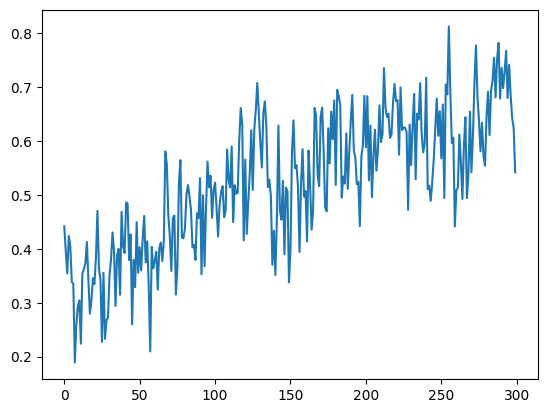

In [10]:
#Scatter plot of thinned acceptance probabilities - change policy_walk to return acceptance probabilities to use
print(np.average(acceptance_probs))
# plt.scatter(range(len(acceptance_probs[14::15])), acceptance_probs[14::15])
# plt.show()

# Moving average of acceptance probabilities
import math
window_size = 500
n_windows = math.floor(len(acceptance_probs)/window_size) 
averages = [] 
for i in range(n_windows): 
    averages.append(np.average(acceptance_probs[window_size*i:window_size*(i+1)]))
plt.plot(averages)
plt.show() 


Analysis of Average Learned Reward Matrix

[ 0.72930333  0.74782457  2.32440021  3.88169149  3.95290732  4.68981012
  5.60659876  6.67260191  8.00796866  8.18060818  8.89009435 10.520485
 10.97891713 11.98194782 12.63623251 13.47545131 15.1590599  15.43415113
 16.72566275 18.1587627 ]


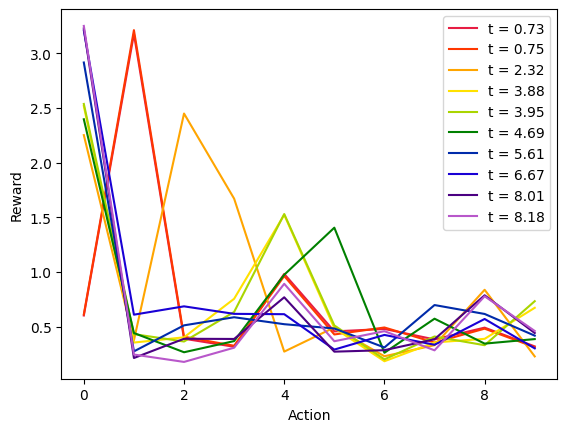

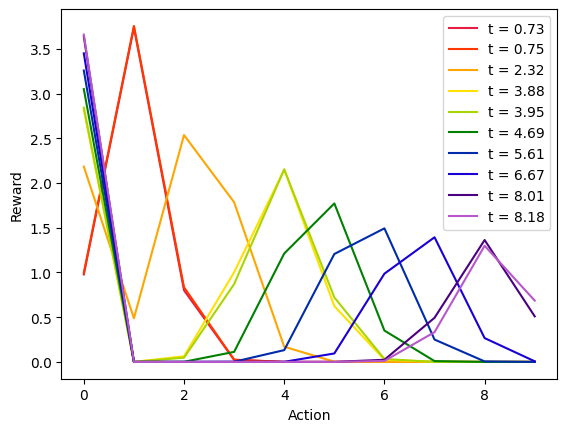

In [12]:
#Shows hte overall learned rewards - switch to the bigger colors array to view all 
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
avg_reward = np.average(np.asarray(learned_rewards[25000:]),axis = 0)
print(observation_times)
s = 0
T = 10
# colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(T):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[s,:,t], color=colors[t*2], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

for t in range(T):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(R[s,:,t], color=colors[t*2], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

Chain Analysis

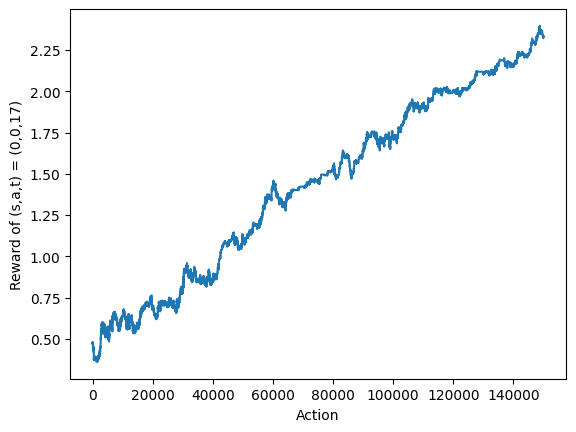

In [7]:
#Used to analyse individual chains: 
# print(observations)

#Plot a single reward
s,a,t = 0,0,17
plt.plot(learned_rewards[:,s,a,t])
ylabel = "Reward of (s,a,t) = (" + format(s) + "," + format(a) + "," + format(t) + ")"
plt.ylabel(ylabel)
plt.xlabel("Action")
plt.show()

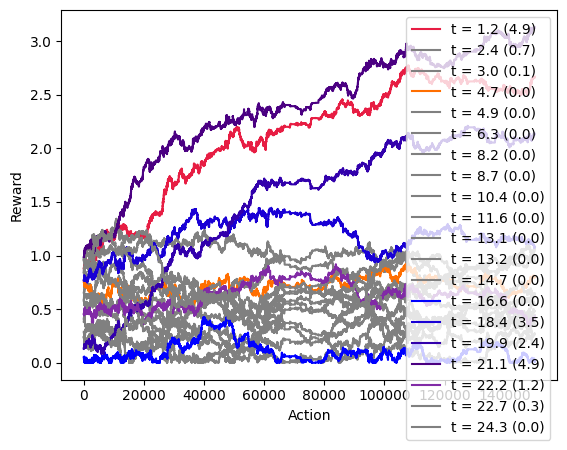

<Figure size 1600x1600 with 0 Axes>

In [8]:
#Plot rewards over time for a given state/action pair - shows observed (s,a,t) pairs in colour 
# print(observations)

#I could try plotting like true reward vs assigned reward over time or something to better visualise idk oh maybe do colours based on reward 
s,a, = 1,1
# s,t = 0,5
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
for t in range(20):
    label = "t = " + format(round(observation_times[t],1)) + " (" + format(round(R[s,a,t],1)) + ")"
    if [s,a,t] in observations: 
        plt.plot(learned_rewards[:,s,a,t], color=colors[t], label = label)
    else:
        plt.plot(learned_rewards[:,s,a,t], color="grey", label = label)        
    
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.figure(figsize=(10,10), dpi=160)
plt.show()

Histogram Plots:

(112500, 20, 25)
[ 1.48342621  2.06145444  2.66023105  2.85876303  3.69473798  4.4269524
  5.01892834  6.73868046  8.50439363  9.64882156 10.79916827 12.29513518
 13.58271763 14.45882027 14.87027309 16.4749117  18.36470026 18.91622971
 20.22683265 20.42231037 21.18033258 22.46754857 23.42372582 24.21892929
 25.92169535]


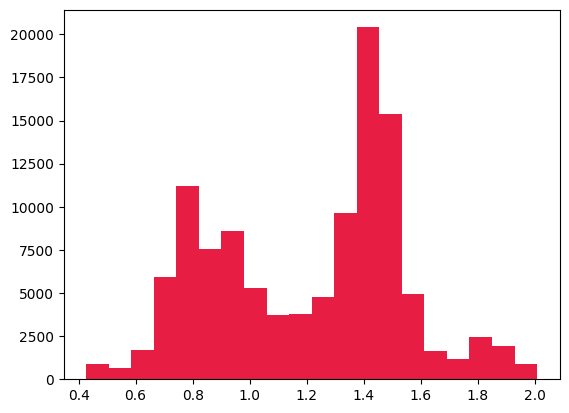

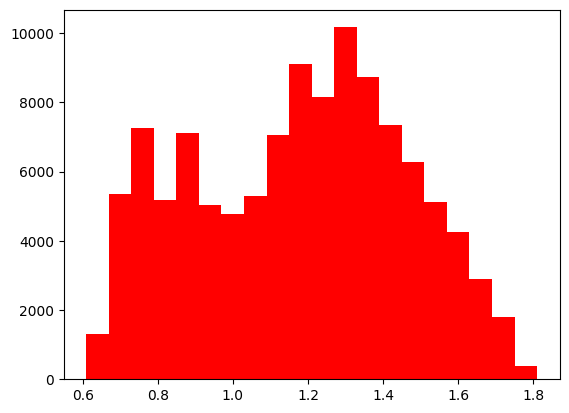

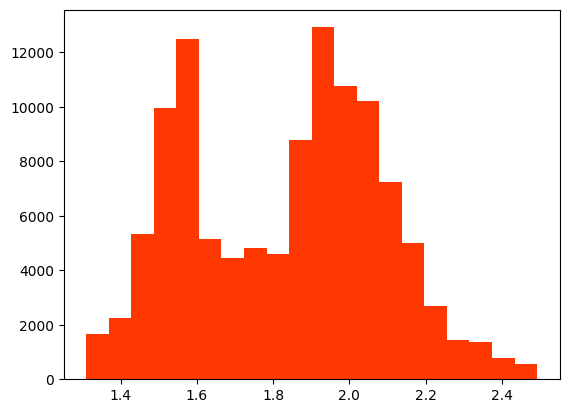

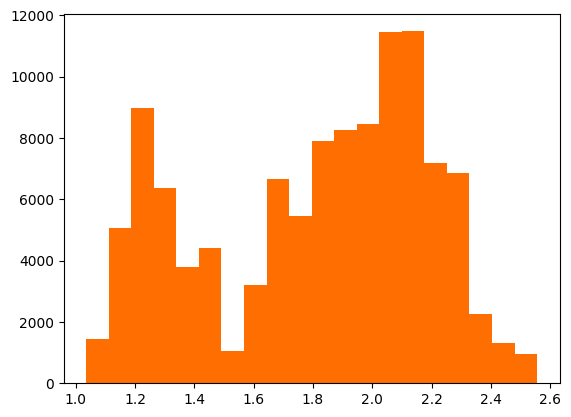

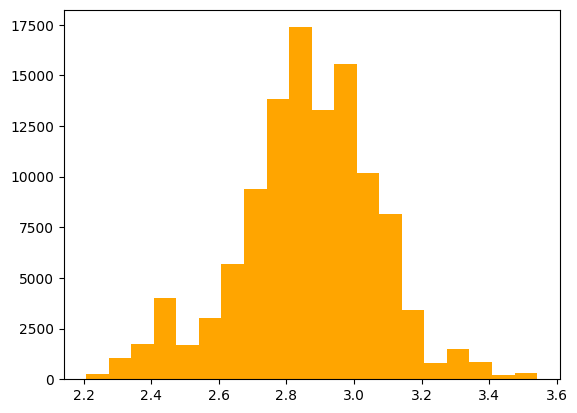

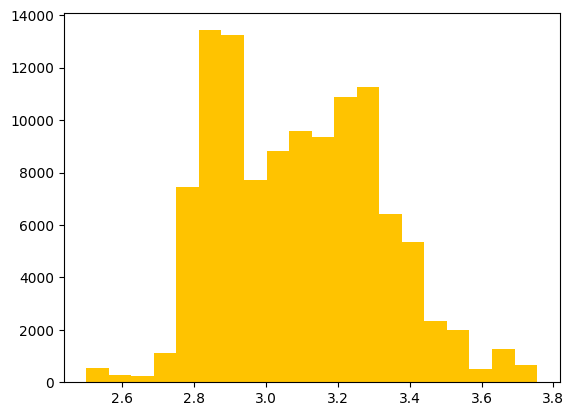

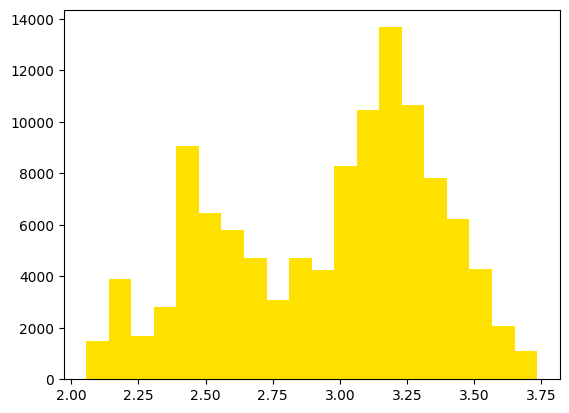

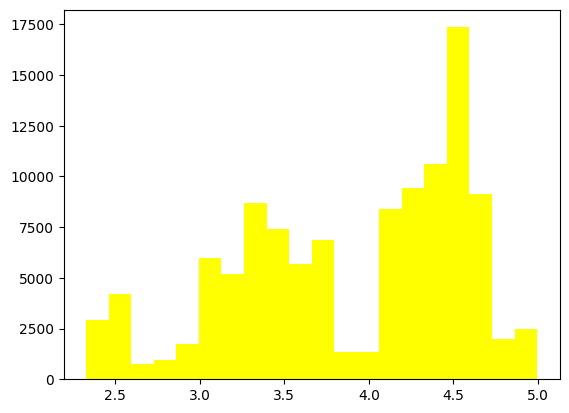

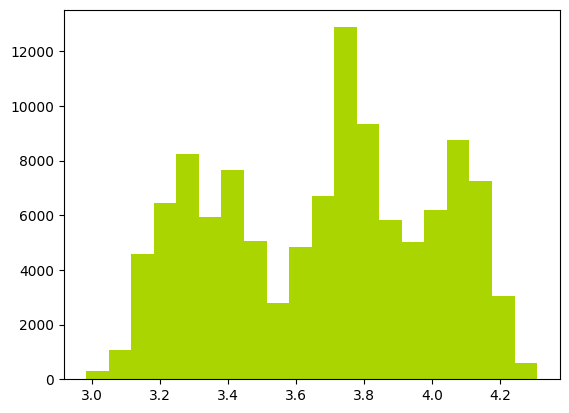

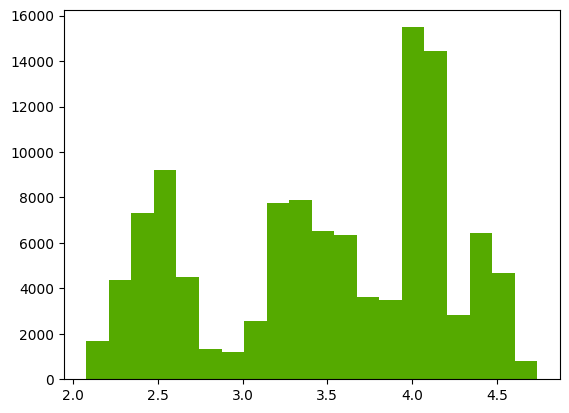

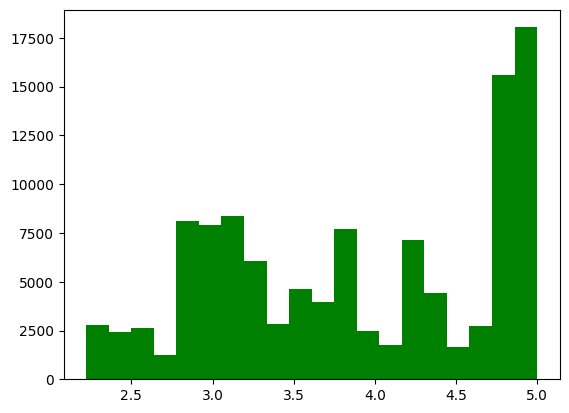

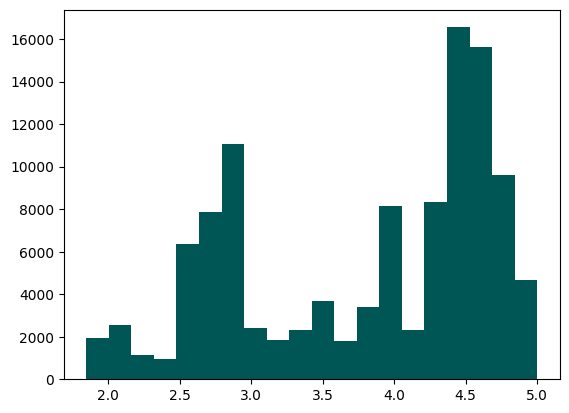

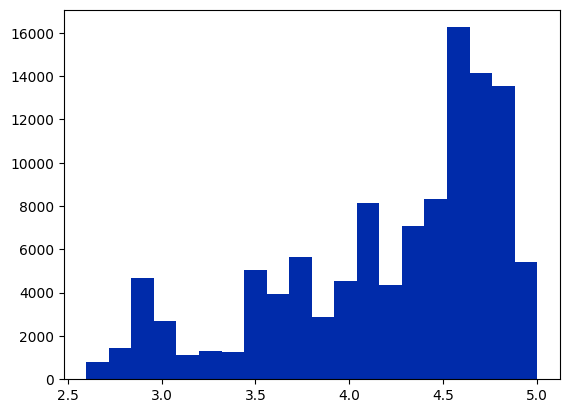

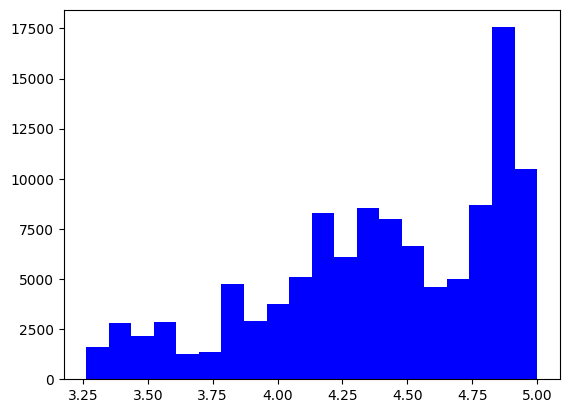

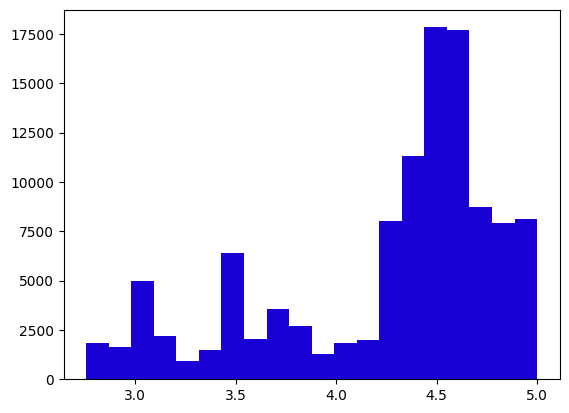

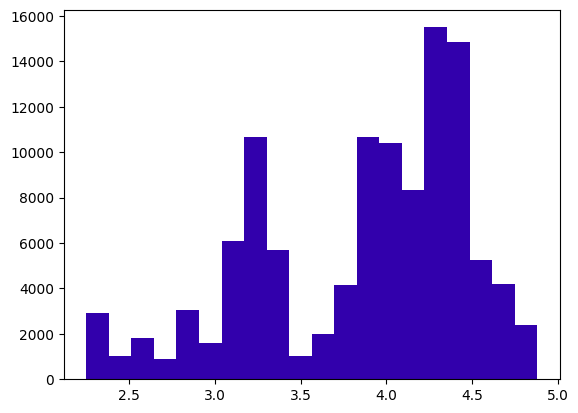

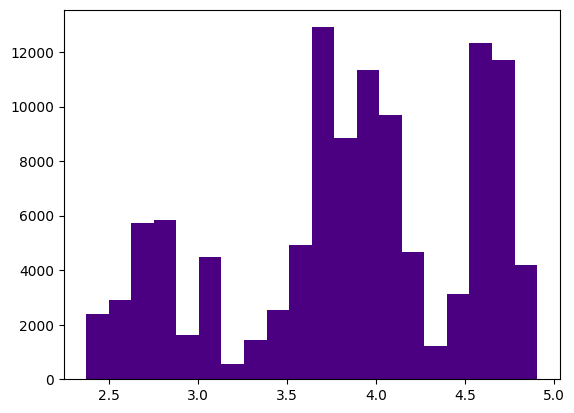

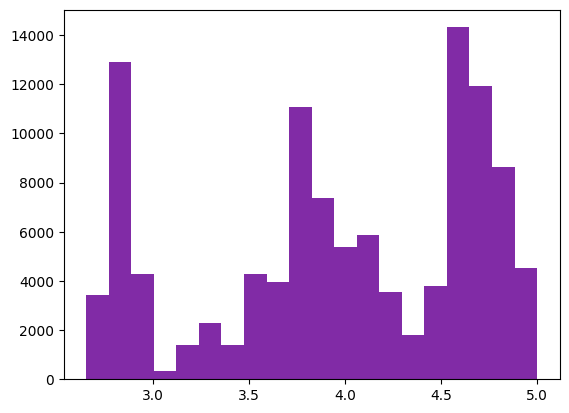

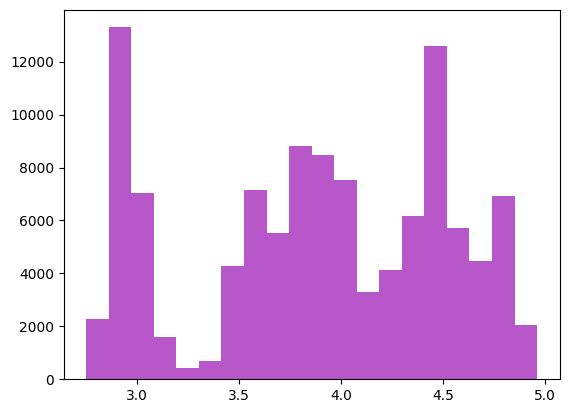

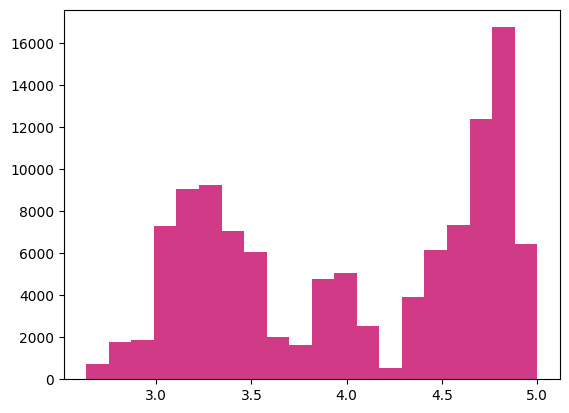

In [70]:
converged_rewards = learned_rewards[37500:]
np.swapaxes(converged_rewards,1,2)
converged_rewards = np.reshape(converged_rewards, (converged_rewards.shape[0], converged_rewards.shape[1]*converged_rewards.shape[2], converged_rewards.shape[3]))
print(converged_rewards.shape)
print(observation_times)
s,a,t = 0,2,0
for t in range(20): #so this should be like state 0 and any action, I kinda want any action that's not 0 but that's gonna be effortso this is kinda pointless actually lol I wanted to visualise it diminishing with time 
    #as greed decays 
    plt.hist(converged_rewards[:,s,t],bins = 20,color=colors[t])
    plt.show()